In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from scipy.sparse.linalg import svds
from matplotlib.colors import LinearSegmentedColormap

In [2]:
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /Users/sashko/Documents/code/python/eeg_llm/sep_uwgr_prepro.fdt


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_32616/2354897670.py:1: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: ['1']
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [3]:
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [4]:
U, S, Vh = np.linalg.svd(avg_data, full_matrices=True)

In [5]:
# This saves up a lot of compute but the order of singular values is not guaranteed
U_2, S_2, Vh_2 = svds(avg_data.T, k=2)

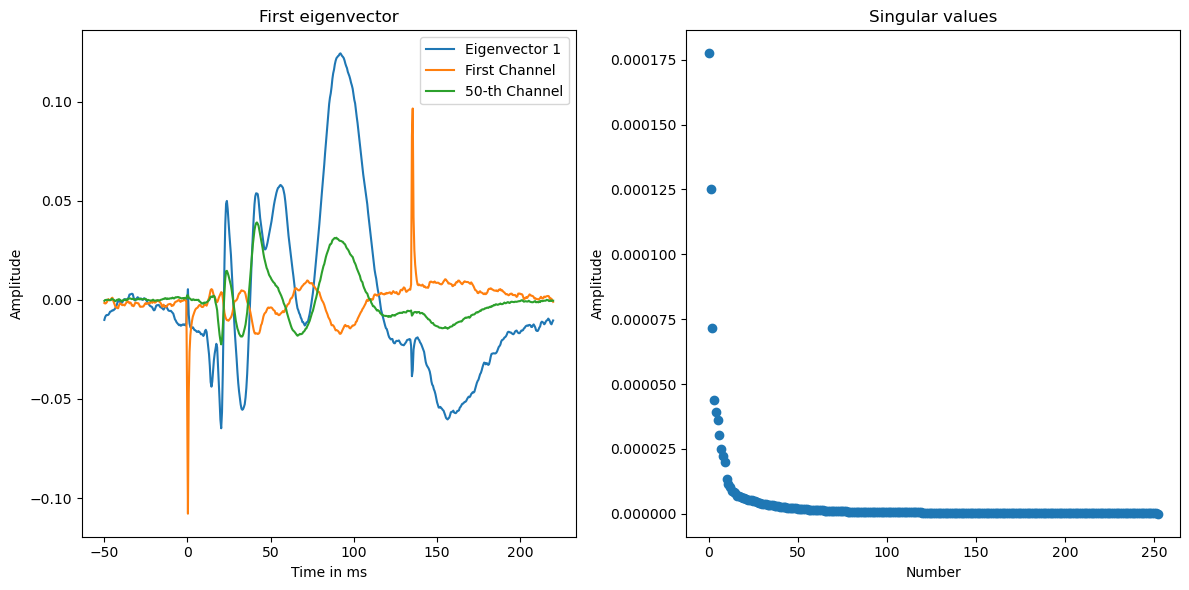

In [6]:
timepoints = np.linspace(tmin, tmax, 554)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
eig_n = 0

ax1.plot(timepoints * 1000, Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0] * 10000, label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49] * 10000, label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(S.T,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

In [7]:
data_reshaped = data.reshape((3345052, 253))

In [8]:
proj_U1 = np.dot(U[:, 0], data_reshaped.T)
proj_U2 = np.dot(U[:, 1], data_reshaped.T)

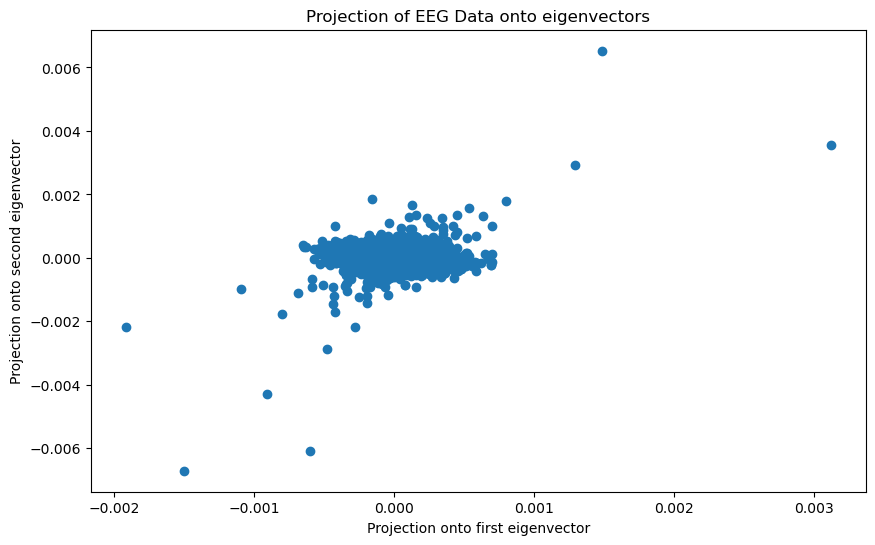

In [9]:
# data is more elongated around first eigenvector
plt.figure(figsize=(10, 6))
plt.scatter(proj_U1, proj_U2)
plt.xlabel('Projection onto first eigenvector')
plt.ylabel('Projection onto second eigenvector')
plt.title('Projection of EEG Data onto eigenvectors')
plt.show()

In [10]:
proj_U1 = np.dot(U.T[0], data)
proj_U2 = np.dot(U.T[1], data)

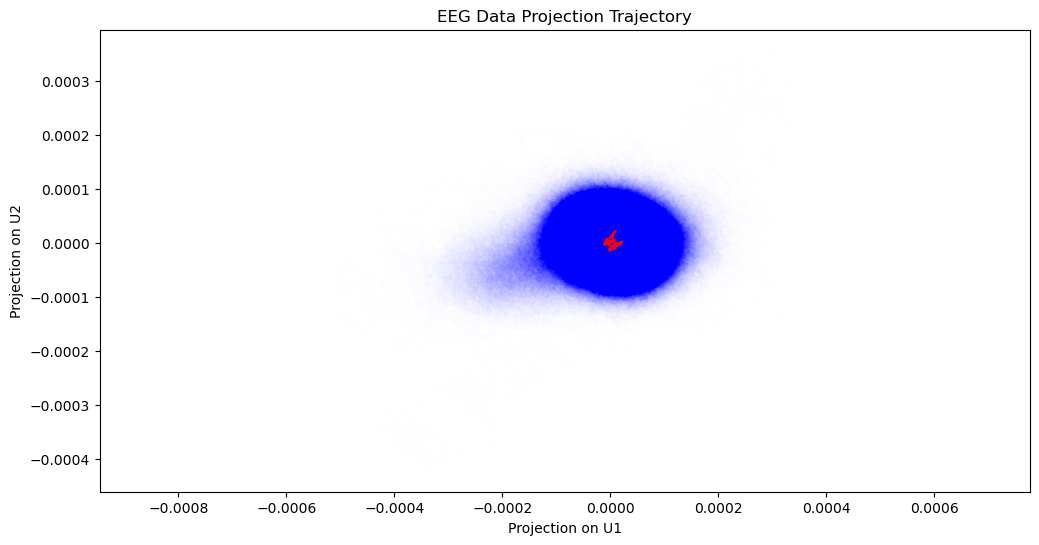

In [11]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1, proj_U2):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(S[0]*Vh[0], S[1]*Vh[1], color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.axis('equal')
plt.show()

In [19]:
# get epochs, channels and timepoints and create list to store principle components for each epoch 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

epochs, channels, timepoints = data.shape
num_components = 5
components_array = np.zeros((epochs,num_components,timepoints))
sing_vals_array = np.zeros((epochs,num_components))
explained_vars = np.zeros((epochs,num_components))
U_array = np.zeros((epochs,channels,num_components))

for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA 
    #pca_per_trial =  PCA()
    #X_transformed = pca_per_trial.fit_transform(epoch_data)

    U_per_trial, sing_vals, components = svds(epoch_data, num_components)

    components_array[epoch] = components[::-1]
    sing_vals_array[epoch] = sing_vals[::-1]
    # explained_var_trial = explained_variance_ratio(sing_vals, sing_vals.shape[0])
    explained_vars[epoch] = explained_variance_ratio(sing_vals[::-1], sing_vals.shape[0])
    U_array[epoch] = U_per_trial[::-1]

    # get first five principal components and singular values 
    # components = pca_per_trial.components_[:5]
    # components_list.append(components)
    #sing_vals = pca_per_trial.singular_values_
    #sing_vals_list.append(sing_vals)
    #explained_var_trial = explained_variance_ratio(sing_vals, sing_vals.shape[0])
    #explained_vars.append(explained_var_trial)
    #U_per_trial = (X_transformed / sing_vals)[:5] 
    #U_list.append(U_per_trial)


# get mean over all epochs
# components_array = np.array(components_list)
avg_explained_var = np.mean(explained_vars, axis=0)
avg_V = np.mean(components_array, axis=0)
avg_S = np.mean(sing_vals_array, axis=0)
avg_U = np.mean(U_array, axis=0)

100%|██████████| 6038/6038 [00:20<00:00, 301.31it/s]


In [20]:
# apply PCA to average data 
pca = PCA(n_components=2)
pca.fit(avg_data)

first_two_comp = pca.components_

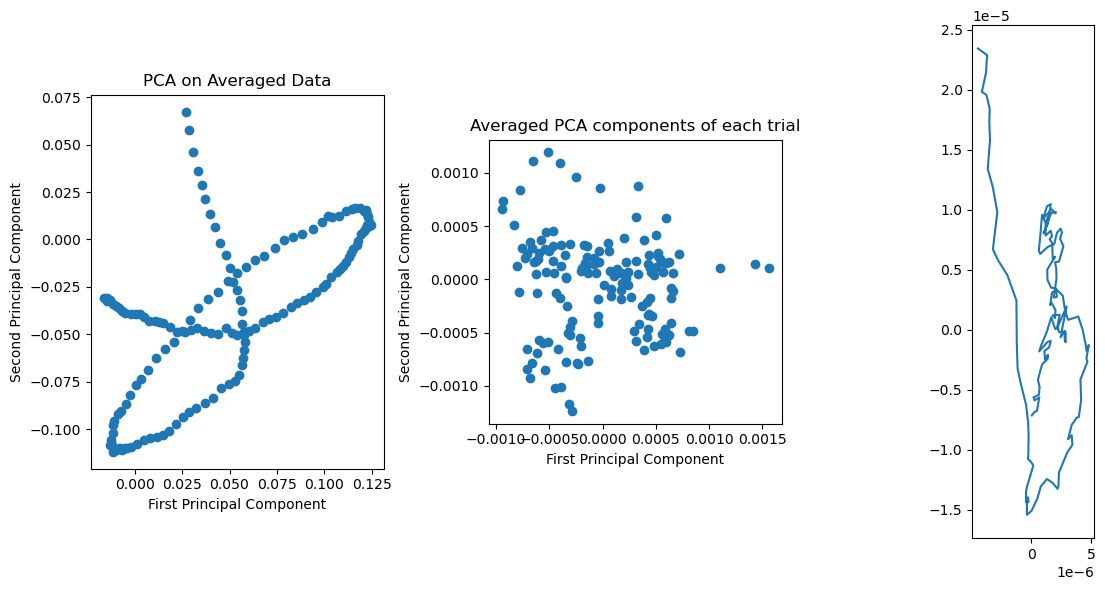

In [21]:
# create figure with two subplots 

t1 = 200
t2 = 350

fig, axes = plt.subplots(1, 3, figsize=(12,6))

# first subplot of eigenvectors of averaged data 
axes[0].scatter(first_two_comp[0][t1:t2], first_two_comp[1][t1:t2])
axes[0].set_title('PCA on Averaged Data')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_aspect('equal')

# second subplot of averaged eigenvectors of each trial 
axes[1].scatter(avg_V[0][t1:t2], avg_V[1][t1:t2])
axes[1].set_title('Averaged PCA components of each trial')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_aspect('equal')

# 
axes[2].plot((np.linalg.inv(np.diag(avg_S)) @ np.dot(avg_U.T, avg_data))[0][t1:t2],(np.linalg.inv(np.diag(avg_S)) @ np.dot(avg_U.T, avg_data))[1][t1:t2])
axes[2].set_aspect('equal')


plt.tight_layout()
plt.show()

In [26]:
proj_U1_avg = np.dot(avg_U[:,0], data)
proj_U2_avg = np.dot(avg_U[:,1], data)

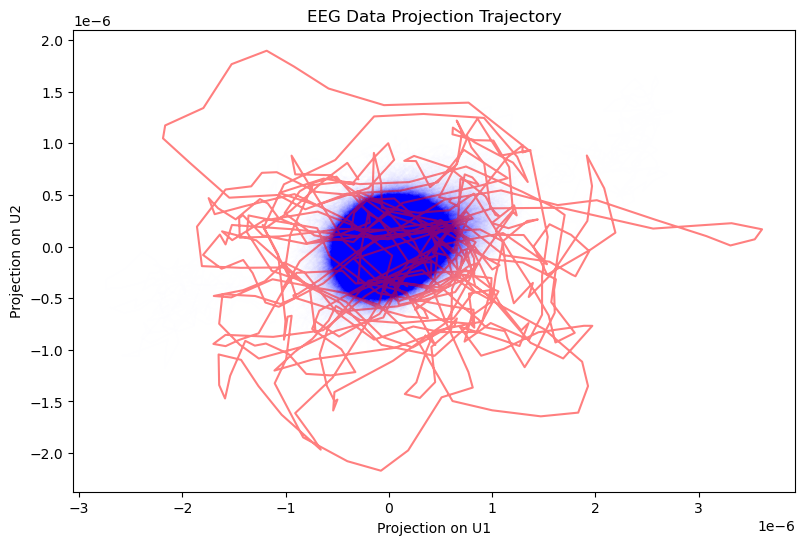

In [27]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1_avg, proj_U2_avg):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(avg_S[0]*avg_V[0], avg_S[1]*avg_V[1], alpha=0.5, color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.gca().set_aspect('equal')
plt.show()

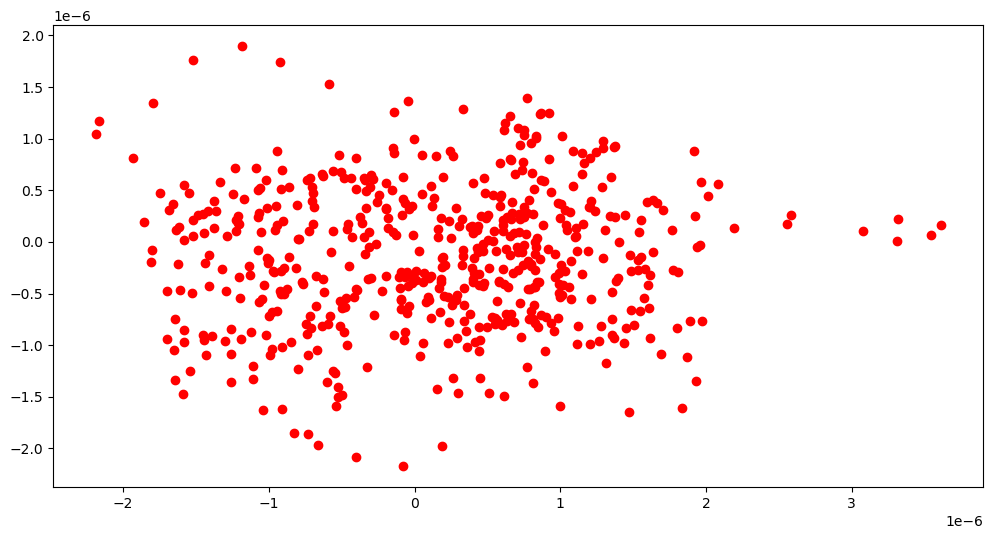

In [28]:
# plot only trajectory 
plt.figure(figsize=(12, 6))
plt.scatter(avg_V[0] * avg_S[0], avg_V[1] * avg_S[1], color='red')
plt.show()

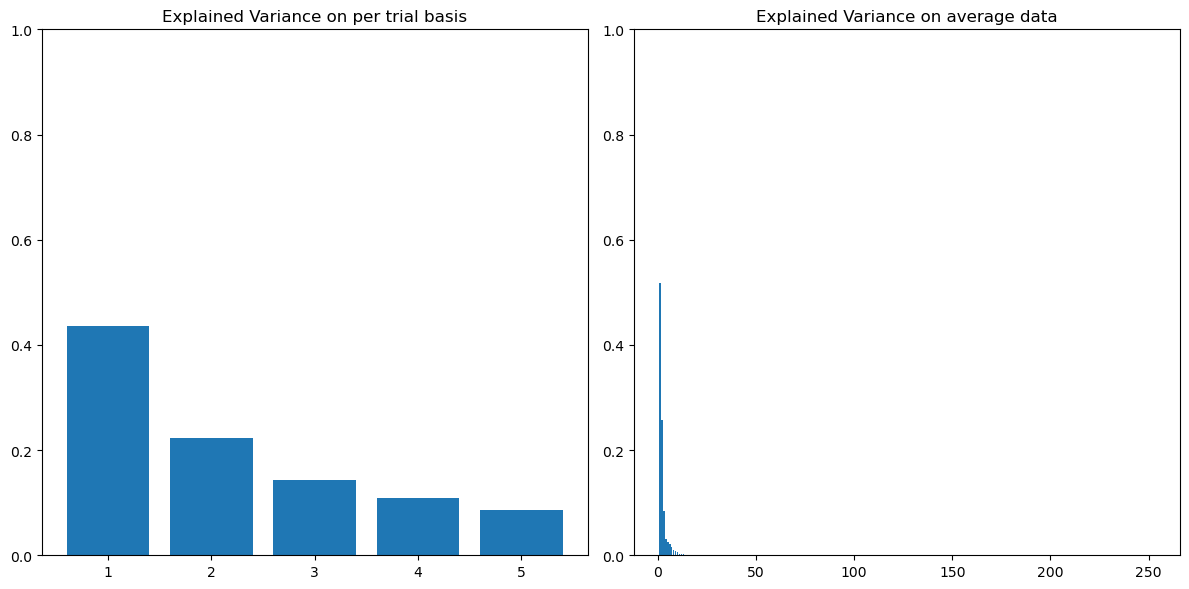

In [29]:
# get explained variance of linear PCA on a per trial basis and on average data 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

explaned_var_ratio_avg = explained_variance_ratio(S, S.shape[0])
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# plot explained variance on per trial basis 
axes[0].bar(range(1, len(avg_explained_var) + 1), avg_explained_var, align='center')
axes[0].set_ylim(0, 1)
axes[0].set_title('Explained Variance on per trial basis')

# plot explained variance of averaged data 
axes[1].bar(range(1, len(explaned_var_ratio_avg) + 1), explaned_var_ratio_avg, align='center')
axes[1].set_ylim(0, 1)
axes[1].set_title('Explained Variance on average data')

plt.tight_layout()
plt.show()

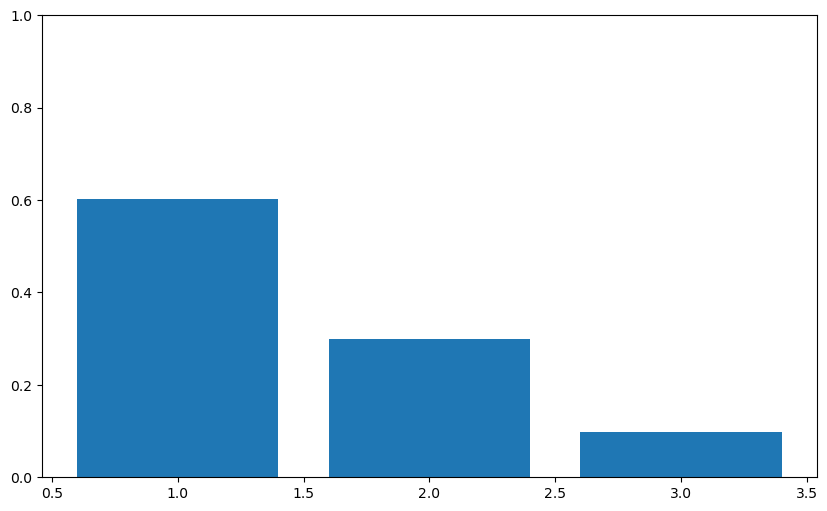

In [30]:
# get the importance of eigenvalues for KernelPCA, note that the explained variance ratio cannot be computed explitely, since the kernel matrix does not correspond to the covariance matrix 
kpca = KernelPCA(kernel='rbf', n_components=3)
kpca.fit(avg_data.T)

lambdas = kpca.eigenvalues_
explained_variance_ratio = lambdas / np.sum(lambdas)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.ylim(0, 1)
plt.show()

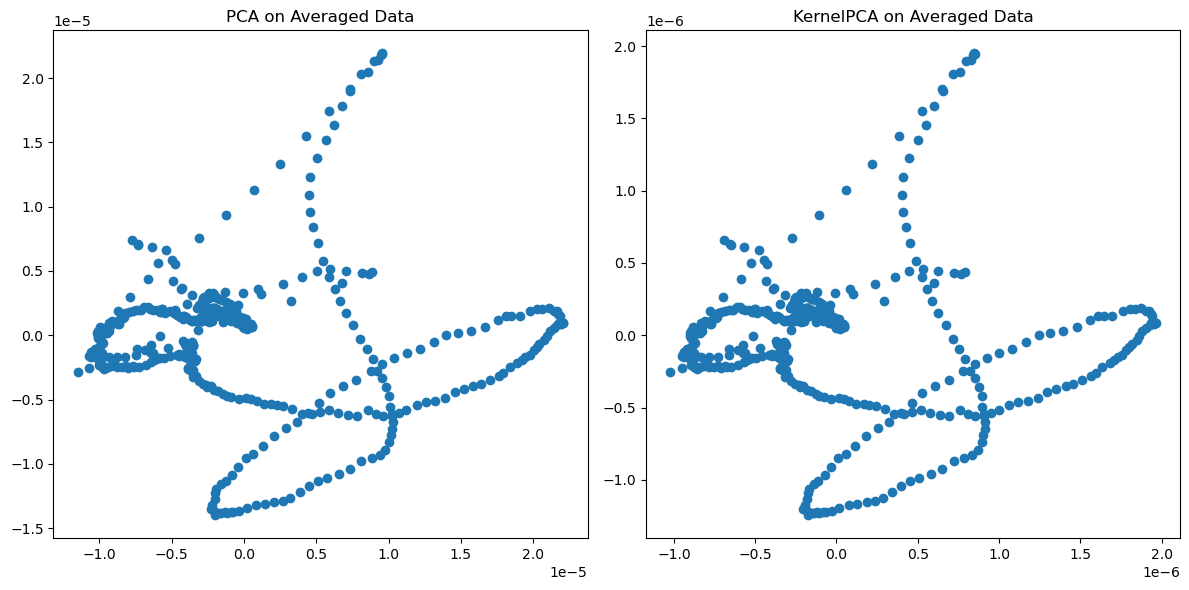

In [31]:
# This may indicate that KernelPCA works a little bit better when downprojecting the data, let's examine this 
pca_transf = pca.fit_transform(avg_data.T)
kpca_transf = kpca.fit_transform(avg_data.T)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(pca_transf[:, 0], pca_transf[:, 1])
axes[0].set_title('PCA on Averaged Data')

axes[1].scatter(kpca_transf[:, 0], kpca_transf[:, 1])
axes[1].set_title('KernelPCA on Averaged Data')

plt.tight_layout()
plt.show()

In [26]:
# As can be seen KernelPCA did not accomplish anything, which Linear PCA was not already capable of doing
epochs, channels, timepoints = data.shape
first_eig_vec_of_each_epoch = []


for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA 
    pca_per_trial =  PCA(n_components=2)
    X_transformed = pca_per_trial.fit(epoch_data)

    # get first two principle components
    eig_vec = pca_per_trial.components_
    first_eig_vec_of_each_epoch.append(eig_vec)


# store all principle components in an array
first_eig_vec_of_each_epoch = np.array(first_eig_vec_of_each_epoch)

100%|██████████| 6038/6038 [00:24<00:00, 244.52it/s]


In [250]:
first_eig_vec_of_each_epoch.shape

(6038, 2, 554)

In [28]:
# compute similarity matrices, meaning each pairwise dot product of the eigenvectors of each epoch to understand the differences in dynamics of each epoch 
first_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 0, :] @  first_eig_vec_of_each_epoch[:, 0, :].T)
second_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 1, :] @  first_eig_vec_of_each_epoch[:, 1, :].T)

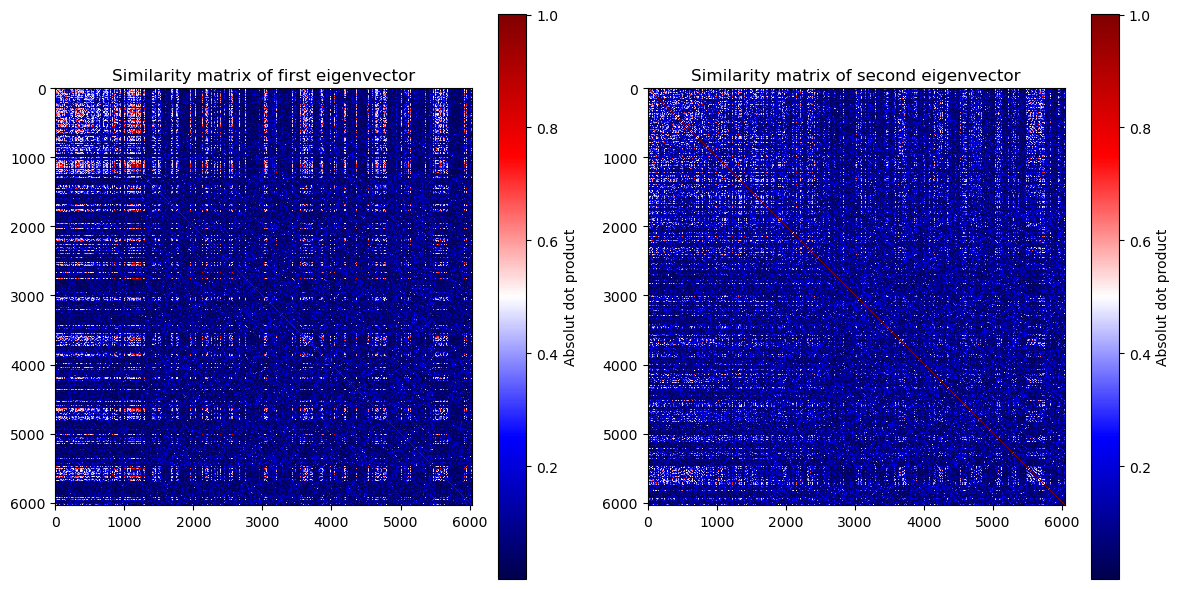

In [29]:
# plot the similarity matrices for the first two principal components 
fig, axes = plt.subplots(1, 2, figsize=(12,6))


im_1 = axes[0].imshow(first_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolut dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolut dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

plt.tight_layout()
plt.show()

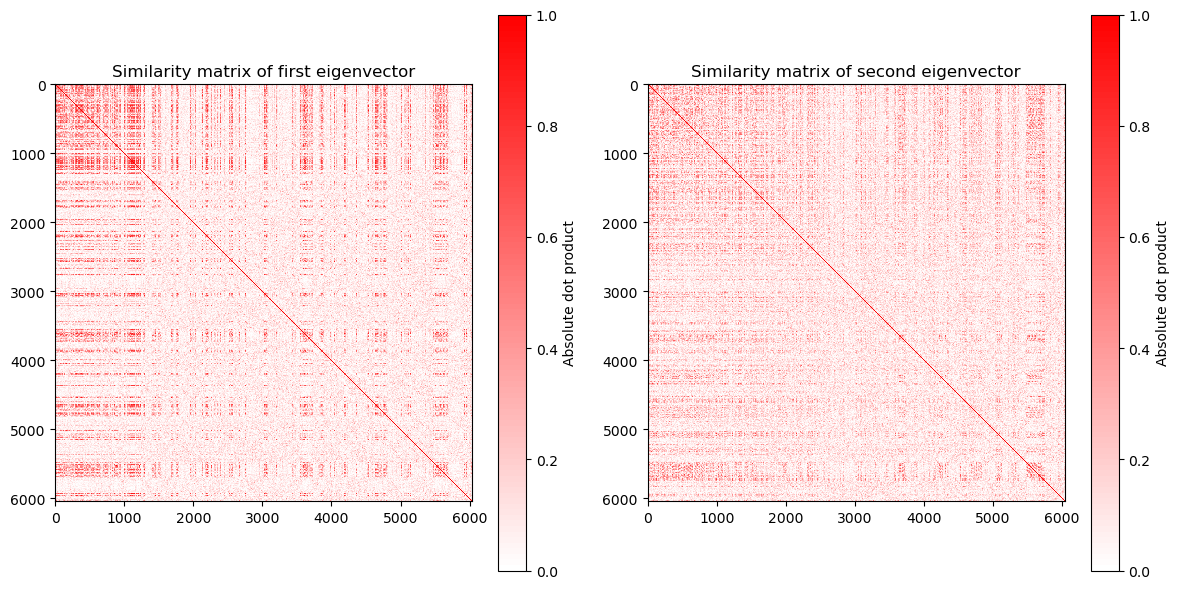

In [30]:
# Create a custom colormap to enhance visualizing the eigenvectors with high similarity 
colors = [(1, 1, 1), (1, 0, 0)]  
n_bins = 100 
cmap_name = 'white_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im_1 = axes[0].imshow(first_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolute dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolute dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

plt.tight_layout()
plt.show()


In [31]:
# thresholding the similarities of the eigenvectors 
threshold = 0.5
num_epochs = 1000
count = np.sum(first_similarity_matrix > threshold, axis=1)
epochs_with_high_sim = np.where(count >= num_epochs)[0]

In [32]:
epochs_with_high_sim.shape

(249,)

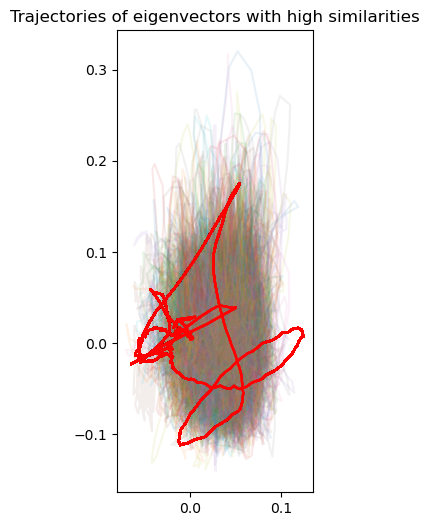

In [33]:
first_eig_vecs_high_sim = first_eig_vec_of_each_epoch[epochs_with_high_sim, 0, :]
second_eig_vecs_high_sim = first_eig_vec_of_each_epoch[epochs_with_high_sim, 1, :]

fig, ax = plt.subplots(figsize=(12,6))

# plot the first two eigenvectors with high similarities to other epochs 
for i in range(len(epochs_with_high_sim)):
    ax.plot(first_eig_vecs_high_sim[i], second_eig_vecs_high_sim[i], alpha=0.1)
    ax.plot(first_two_comp[0], first_two_comp[1], color='red')
    ax.set_aspect('equal')
ax.set_title('Trajectories of eigenvectors with high similarities')


plt.show()

In [60]:
from scipy.linalg import subspace_angles

U_list = np.array(U_list)
plane_sim = np.zeros((U_list.shape[0],U_list.shape[0]))

for i in tqdm(range(U_list.shape[0])):
    for j in range(i, U_list.shape[0]):
        plane_sim[i,j] = np.cos(subspace_angles(U_list[i].T, U_list[j].T))[1]

100%|██████████| 6038/6038 [16:04<00:00,  6.26it/s] 


In [32]:
dot_product_matrices = np.tensordot(components_array, components_array.T,1).transpose(0,3,1,2)
similarity = np.linalg.svd(dot_product_matrices, compute_uv=False)
similarity = similarity[:,:,0]

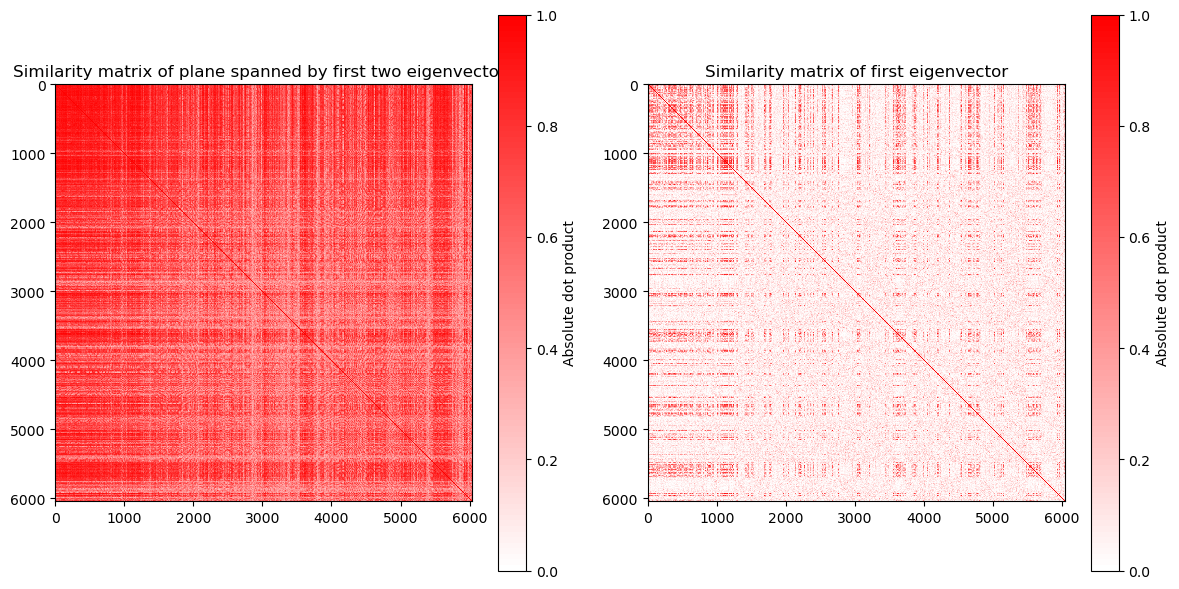

In [33]:
# Create a custom colormap to enhance visualizing the eigenvectors with high similarity 
colors = [(1, 1, 1), (1, 0, 0)]  
n_bins = 100 
cmap_name = 'white_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


fig, axes = plt.subplots(1,2,figsize=(12,6))

im_1 = axes[0].imshow(similarity, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolute dot product')
axes[0].set_title('Similarity matrix of plane spanned by first two eigenvectors')

im_2 = axes[1].imshow(np.abs(dot_product_matrices.diagonal(axis1=2,axis2=3)[:,:,0]), cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolute dot product')
axes[1].set_title('Similarity matrix of first eigenvector')

plt.tight_layout()
plt.show()